# PCA - An example on Exploratory Data Analysis

We will:

- Replicate Andrew's example on PCA
- Visualize how PCA works on a 2-dimensional small dataset and that not every projection is "good"
- Visualize how a 3-dimensional data can also be contained in a 2-dimensional subspace
- Use PCA to find hidden patterns in a high-dimensional dataset

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
import matplotlib.pyplot as plt
import plotly.offline as py

In [2]:
from __future__ import division
import numpy as np
from bokeh.core.properties import Instance, String
from sklearn.decomposition import PCA
from bokeh.io import output_notebook, push_notebook,show
from bokeh.layouts import row, column
from bokeh.models import Slider,Range1d,ColumnDataSource, LayoutDOM
from bokeh.plotting import figure, show
from bokeh.util.compiler import TypeScript
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as py
import numpy as np
from ipywidgets import interactive, HBox, VBox
import plotly.express as px


X = np.array([[-0.83934975, -0.21160323],
       [ 0.67508491,  0.25113527],
       [-0.05495253,  0.36339613],
       [-0.57524042,  0.24450324],
       [ 0.58468572,  0.95337657],
       [ 0.5663363 ,  0.07555096],
       [-0.50228538, -0.65749982],
       [-0.14075593,  0.02713815],
       [ 0.2587186 , -0.26890678],
       [ 0.02775847, -0.77709049]])


import numpy as np
def orthogonal_projection(p,n):
    """
    Given a normal vector to a plane, n and a point of space p, computes the orthogonal projection of p into the plane
    Input:
        p: numpy array
        n: numpy array
    Output:
        numpy array
    """
    n = np.array(n)
    p = np.array(p)
    lambda_val = np.dot(p,n)/np.dot(n,n)
    return p - lambda_val * n

def orthogonal_set_projection(P,n):
    """
    Given a normal vector to a plane, n and a set of points in space P, computes the orthogonal projection of each point
    Input:
        P: numpy array (or any iterable) of points in space
        n: numpy array
    Output:
        numpy array of arrays with the orthogonal projections
    """
    l = []
    for p in P:
        l.append(orthogonal_projection(p,n))
    return np.array(l)

def plot_line(plt,f, domain = [-1,1], **kwargs):
    f_x = [f(x) for x in domain]
    return plt.line(domain,f_x, **kwargs)



def get_plane_base(P,n):
    a,b = n
    n = n/np.linalg.norm(n)
    if b == 0:
        v = np.array([0,1])
    else:
        v = np.array([1,-a/b])
    v = v/np.linalg.norm(v)
    m = np.array([v,n])
    P_changed = []
    for p in P:
        P_changed.append(m@p)
    return np.array(P_changed)
        

def random_point_circle(center=(0,0),radius=1,n=1):
    r = radius * np.sqrt(np.random.rand(n))
    theta = np.random.rand(n) * 2 * np.pi
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    return np.array([x,y]).T


def rotation_matrix(angle):
    radians = angle*np.pi/180
    return np.matrix([[np.cos(radians), -np.sin(radians)], [np.sin(radians), np.cos(radians)]]).round(4)

def line_between_points(ax,p1,p2,**kwargs):
    return ax.line(x=[p1[0],p2[0]],y=[p1[1],p2[1]],**kwargs)

## Fits the PCA with 2 dimensions
pca = PCA(n_components = 2).fit(X)
pca_line = np.array([k*pca.components_[0] for k in [-1.5,1.5]])
orthogonal_set = orthogonal_set_projection(X,(0,1))

def plot_widget_2(doc):
    main_plot = figure(width=500, height=500)
    main_plot.grid.visible = False
    main_plot.xaxis.visible = False
    main_plot.yaxis.visible = False
    main_plot.outline_line_color = None 
    main_plot.toolbar.logo = None
    main_plot.toolbar_location = None
    main_plot.x_range=Range1d(-1.5, 1.5)
    main_plot.y_range=Range1d(-1.5, 1.5)
    ## Main scatter plot (static)
    main_scatter = main_plot.scatter(X[:,0],X[:,1],marker = 'o', size = 4, color = "#C00000")

    ## PCA line (static)
    pca_line_plot = line_between_points(main_plot,pca_line[0],pca_line[1], color = '#333333', line_width = 1.5, legend_label = "PCA Line")

    ## Rotating line initial state:
    rotating_line_initial_state = [(-1.5,0), (1.5,0)]

    rotating_line = line_between_points(main_plot,
                                        rotating_line_initial_state[0], 
                                        rotating_line_initial_state[1], 
                                        color = '#0096FF',
                                        line_width = 1.5
                                        )

    projection_points = main_plot.scatter(orthogonal_set[:,0],
                                          orthogonal_set[:,1],
                                          marker = 'x', 
                                          size = 10, 
                                          color = "#C00000",
                                          legend_label = "Projected Points")

    lines = []*len(X)
    for p,o in zip(X,orthogonal_set):
        lines.append(line_between_points(main_plot,p,o,color='#FF9300', line_width = 1))

    rhs_plot = figure(width=500, height=500)
    rhs_plot.grid.visible = False
    rhs_plot_points = get_plane_base(orthogonal_set,(0,1)).round(2)
    line_between_points(rhs_plot,[-1,0],[1.15,0], color = "#0096FF",line_width = 1.5)
    rhs_scatter = rhs_plot.scatter(rhs_plot_points[:,0], rhs_plot_points[:,1], color = "#C00000", size = 5, marker = "x")
    rhs_plot.xaxis.visible = False
    rhs_plot.yaxis.visible = False
    rhs_plot.outline_line_color = None
    rhs_plot.toolbar.logo = None
    rhs_plot.toolbar_location = None
    rhs_plot.x_range=Range1d(-1.5, 1.5)

    slider = Slider(
        title="Adjust rotation angle",
        start=0,
        end=360,
        value= 0,
        step=1,

    )
    data = rotating_line.data_source.data
    p0 = np.array([data['x'][0],data['y'][0]])
    p1 = np.array([data['x'][1],data['y'][1]])
    def update(attr,old,new):
        ang = new
        # Rotate both points
        p0r = rotation_matrix(ang)@p0
        p1r = rotation_matrix(ang)@p1
        # This is the normal vector to the rotated line. 
        if abs(p0r[0] - p1r[0]) < 1e-10:
            n_line = (1,0)
        else:
            n_line = (-(p0r[1] - p1r[1])/(p0r[0] - p1r[0]), 1)
        # The code below just update every plot we just created above
        orthogonal_to_line = orthogonal_set_projection(X,n_line)
        rotating_line.data_source.data['x'] = [p0r[0],p1r[0]]
        rotating_line.data_source.data['y'] = [p0r[1],p1r[1]]
        projection_points.data_source.data['x'] = orthogonal_to_line[:,0]
        projection_points.data_source.data['y'] = orthogonal_to_line[:,1]
        
        projection_plot_1d = get_plane_base(orthogonal_to_line,n_line)
        rhs_scatter.data_source.data['x'] = projection_plot_1d[:,0]
        
        for line,p,o in zip(lines, X,orthogonal_to_line):
            line.data_source.data['x'] = [p[0],o[0]]
            line.data_source.data['y'] = [p[1],o[1]]
        

    slider.on_change('value',update)
    doc.add_root(row(main_plot,column(slider,rhs_plot)))
    
def plot_3d_2d_graphs(X):
    df = pd.DataFrame(X, columns = ['x1','x2'])
    df['x3'] = df['x1'] + df['x2']
    fig = make_subplots(rows=1, cols=2, specs = [[{"type":"scatter3d"}, {"type":"scatter"}]])


    fig.add_trace(go.Scatter3d(x= df['x1'], 
                      y = df['x2'], 
                      z = df['x3'], 
                      mode = 'markers'),
                      row = 1,
                      col = 1
                        ).update_traces(marker = dict(color = "#C00000", symbol = "x", size = 2),
                                        ).update_layout(scene = dict(xaxis = dict(range = [-1.5,1.5], showgrid=False),
                                                                     xaxis_title = 'x1',
                                                                     yaxis = dict(range = [-1.5,1.5], showgrid = False),
                                                                     yaxis_title = 'x2',
                                                                     zaxis = dict(range = [-1.5,1.5], showgrid = False),
                                                                     zaxis_title = 'x3'))

    fig.add_trace(go.Scatter(x = df.rename(columns = {'x1':'z1'})['z1'],
                             y = df.rename(columns = {'x2':'z2'})['z2'],
                             mode = "markers",
                             showlegend=False
                            ),
                    row = 1,
                    col = 2)
    return fig
    fig.show()
    
def plot_widget():
    main_plot = px.scatter(x = X[:,0], y = X[:,1])

    main_plot.data[0]['marker']['color'] = "#C00000"
    main_plot.data[0]['marker']['symbol'] = "x-thin-open"  
    main_plot.data[0]['marker']['size'] = 10

    
    pca_line_plot = line_between_points(px,pca_line[0],pca_line[1])

    pca_line_plot.data[0]['line']['color'] = "#333333"
    pca_line_plot.data[0]['showlegend'] = True
    pca_line_plot.data[0]['name'] = 'PCA Line'
    ## Rotating line initial state:
    rotating_line_initial_state = [(-2,0), (2,0)]



    rotating_line = line_between_points(px,
                                            rotating_line_initial_state[0], 
                                            rotating_line_initial_state[1]
                                            )



    rotating_line.data[0]['line']['color'] = "#0096FF"
    rotating_line.data[0]['showlegend'] = True
    rotating_line.data[0]['name'] = 'Rotating Line'

    projection_plot = px.scatter(x = orthogonal_set[:,0], y = orthogonal_set[:,1])
    projection_plot.data[0]['showlegend'] = True
    projection_plot.data[0]['name'] = 'Projection Points'

    projection_plot.data[0]['marker']['color'] = "#C00000"
    


    projection_plot_1d = get_plane_base(orthogonal_set,(0,1))
    rhs_scatter = px.scatter(x=projection_plot_1d[:,0],y=projection_plot_1d[:,1])

    rhs_scatter.data[0]['marker']['color'] = "#FF9300"
    final_data = main_plot.data + pca_line_plot.data + rotating_line.data + projection_plot.data
    rhs_initial_point = [-1.5,0]
    rhs_final_point = [1.5,0]
    rhs_line = line_between_points(px,rhs_initial_point,rhs_final_point)
    rhs_line.data[0]['line']['color'] = "#0096FF"
    
    lines = []*len(X)
    for p,o in zip(X,orthogonal_set):
        line = line_between_points(px,p,o)
        line.data[0]['line']['color'] = "#FF9300"
        lines.append(line)
        final_data = line.data + final_data


    p0 = np.array([rotating_line.data[0]['x'][0],rotating_line.data[0]['y'][0]])
    p1 = np.array([rotating_line.data[0]['x'][1],rotating_line.data[0]['y'][1]])
    def update_orthogonal_line(i,p,o):
        fig.data[i]['x'] = np.array([p[0],o[0]])
        fig.data[i]['y'] = np.array([p[1],o[1]])

    n_line = (1,0)

    def update(angle):
        ang = angle
        with fig.batch_update():
            p0r = rotation_matrix(ang)@p0
            p1r = rotation_matrix(ang)@p1
            # This is the normal vector to the rotated line. 
            if abs(p0r[0] - p1r[0]) < 1e-10:
                n_line = (1,0)
            else:
                n_line = (-(p0r[1] - p1r[1])/(p0r[0] - p1r[0]), 1)

        # The code below just update every plot we just created above
            orthogonal_to_line = orthogonal_set_projection(X,n_line)
            dispatches_args = enumerate(zip(X,orthogonal_to_line))
            for i,(o,p) in dispatches_args:
                fig.data[i]['x'] = np.array([p[0],o[0]])
                fig.data[i]['y'] = np.array([p[1],o[1]])
            fig.data[-2]['x'] = np.array([p0r[0],p1r[0]])
            fig.data[-2]['y'] = np.array([p0r[1],p1r[1]])
            fig.data[-1]['x'] = orthogonal_to_line[:,0]
            fig.data[-1]['y'] = orthogonal_to_line[:,1]
            projection_plot_1d = get_plane_base(orthogonal_to_line,n_line)
            rhs_fig.data[1]['x'] = np.array(projection_plot_1d[:,0])

    #     projection_plot_1d = get_plane_base(orthogonal_to_line,n_line)
    #     rhs_scatter.data_source.data['x'] = projection_plot_1d[:,0]






    freq_slider = interactive(update, angle=(0, 180, 1))        
    fig = go.FigureWidget(data = final_data ).update_yaxes(scaleanchor = 'x', scaleratio= 1, range = [-1,1], visible=False).update_xaxes(range = [-1.5,1.5], visible=False)
    rhs_fig = go.FigureWidget(data = rhs_line.data + rhs_scatter.data).update_yaxes(scaleanchor = 'x', scaleratio= 1, range = [-1,1], showgrid=False, visible=False).update_xaxes(range = [-1.5,1.5], showgrid=False, visible=False)

    rhs_fig.update_layout(dict(width = 500, height = 400, plot_bgcolor = 'rgba(0,0,0,0)', title="PCA Projection"))

    fig.update_layout(dict(width = 500, height = 570, plot_bgcolor = 'rgba(0,0,0,0)'))

    vb = HBox((fig,(VBox(( freq_slider,rhs_fig)))))
    #vb.layout.align_items = 'center'
    return vb

In [3]:
py.init_notebook_mode()

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
X = np.array([[ 99,  -1],
       [ 98,  -1],
       [ 97,  -2],
       [101,   1],
       [102,   1],
       [103,   2]])

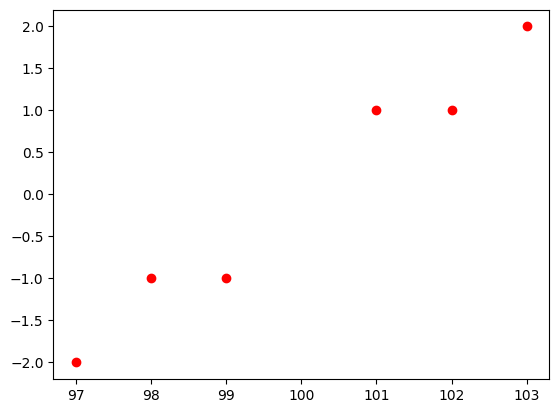

In [6]:
plt.plot(X[:,0], X[:,1], 'ro')

In [9]:
# Loading the PCA algorithm
pca_2 = PCA(n_components=2)
pca_2

PCA(n_components=2)

In [10]:
# Let's fit the data. We do not need to scale it, since sklearn's implementation already handles it.
pca_2.fit(X)

PCA(n_components=2)

In [11]:
pca_2.explained_variance_ratio_

array([0.99244289, 0.00755711])

The coordinates on the first principal component (first axis) are enough to retain 99.24% of the information ("explained variance").  The second principal component adds an additional 0.76% of the information ("explained variance") that is not stored in the first principal component coordinates.

In [12]:
X_trans_2 = pca_2.transform(X)
X_trans_2

array([[ 1.38340578,  0.2935787 ],
       [ 2.22189802, -0.25133484],
       [ 3.6053038 ,  0.04224385],
       [-1.38340578, -0.2935787 ],
       [-2.22189802,  0.25133484],
       [-3.6053038 , -0.04224385]])

Think of column 1 as the coordinate along the first principal component (the first new axis) and column 2 as the coordinate along the second principal component (the second new axis).

We can probably just choose the first principal component since it retains 99% of the information (explained variance).

In [13]:
pca_1 = PCA(n_components=1)
pca_1

PCA(n_components=1)

In [14]:
pca_1.fit(X)
pca_1.explained_variance_ratio_

array([0.99244289])

In [15]:
X_trans_1 = pca_1.transform(X)
X_trans_1

array([[ 1.38340578],
       [ 2.22189802],
       [ 3.6053038 ],
       [-1.38340578],
       [-2.22189802],
       [-3.6053038 ]])

Notice how this column is just the first column of `X_trans_2`.

If we had 2 features (two columns of data) and choose 2 principal components, then we'll keep all the information and the data will end up the same as the original.

In [16]:
X_reduced_2 = pca_2.inverse_transform(X_trans_2)
X_reduced_2

array([[ 99.,  -1.],
       [ 98.,  -1.],
       [ 97.,  -2.],
       [101.,   1.],
       [102.,   1.],
       [103.,   2.]])

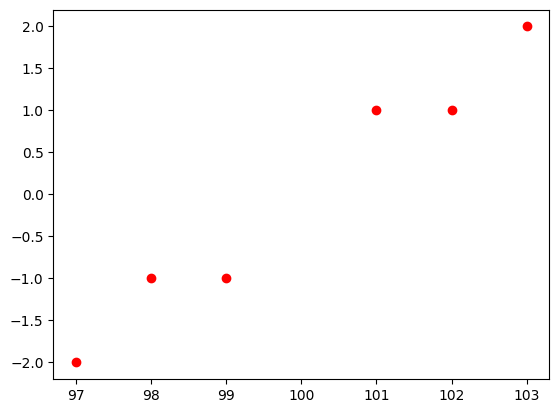

In [17]:
plt.plot(X_reduced_2[:,0], X_reduced_2[:,1], 'ro')

Reduce to 1 dimension instead of 2

In [18]:
X_reduced_1 = pca_1.inverse_transform(X_trans_1)
X_reduced_1

array([[ 98.84002499,  -0.75383654],
       [ 98.13695576,  -1.21074232],
       [ 96.97698075,  -1.96457886],
       [101.15997501,   0.75383654],
       [101.86304424,   1.21074232],
       [103.02301925,   1.96457886]])

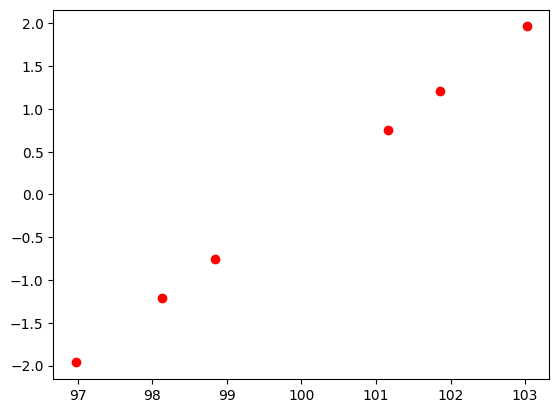

In [19]:
plt.plot(X_reduced_1[:,0], X_reduced_1[:,1], 'ro')

Notice how the data are now just on a single line (this line is the single principal component that was used to describe the data; and each example had a single "coordinate" along that axis to describe its location.

## Visualizing the PCA algorithm

Let's define $10$ points in the plane and use them as an example to visualize how we can compress this points in 1 dimension. You will see that there are good ways and bad ways.

In [20]:
X = np.array([[-0.83934975, -0.21160323],
       [ 0.67508491,  0.25113527],
       [-0.05495253,  0.36339613],
       [-0.57524042,  0.24450324],
       [ 0.58468572,  0.95337657],
       [ 0.5663363 ,  0.07555096],
       [-0.50228538, -0.65749982],
       [-0.14075593,  0.02713815],
       [ 0.2587186 , -0.26890678],
       [ 0.02775847, -0.77709049]])

In [21]:
p = figure(title = '10-point scatterplot', x_axis_label = 'x-axis', y_axis_label = 'y-axis') ## Creates the figure object
p.scatter(X[:,0],X[:,1],marker = 'o', color = '#C00000', size = 5) ## Add the scatter plot

## Some visual adjustments
p.grid.visible = False
p.grid.visible = False
p.outline_line_color = None 
p.toolbar.logo = None
p.toolbar_location = None
p.xaxis.axis_line_color = "#f0f0f0"
p.xaxis.axis_line_width = 5
p.yaxis.axis_line_color = "#f0f0f0"
p.yaxis.axis_line_width = 5

## Shows the figure
show(p)

The next code will generate a widget where you can see how different ways of compressing this data into 1-dimensional datapoints will lead to different ways on how the points are spread in this new space. The line generated by PCA is the line that keeps the points as far as possible from each other. 


In [22]:
plot_widget()

    'data': [{'hovertemplate': 'x=%{x}<br>y=%{y}<extra></extra>',
              …

## Visualization of a 3-dimensional dataset 

In this section we will see how some 3 dimensional data can be condensed into a 2 dimensional space. 

In [23]:
from pca_utils import random_point_circle, plot_3d_2d_graphs

In [24]:
X = random_point_circle(n = 150)

In [25]:
deb = plot_3d_2d_graphs(X)

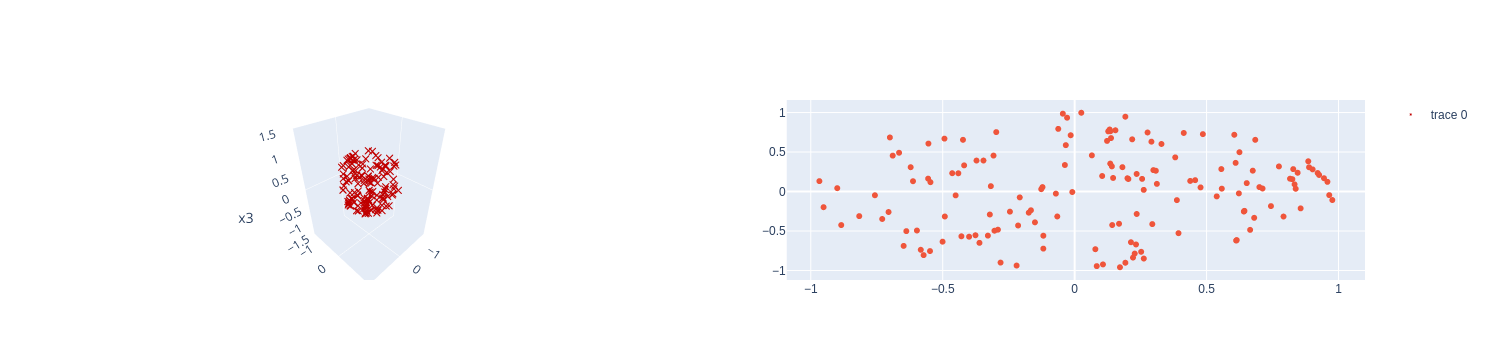

In [26]:
deb.update_layout(yaxis2 = dict(title_text = 'test', visible=True))

## Using PCA in Exploratory Data Analysis

Let's load a toy dataset with $500$ samples and $1000$ features.

In [27]:
df = pd.read_csv("toy_dataset.csv")

In [28]:
df.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  27.422157 -29.662712 -23.297163 -15.161935   0.345581   3.706750   
1   3.489482 -19.153551 -14.636424  14.688258  20.114204  13.532852   
2   4.293509  22.691579  -1.045155  -8.740350  12.401082  31.362987   
3  -2.139348  23.158754 -26.241206  19.426465   9.472049   8.453948   
4 -35.251034  27.281816 -29.470282 -21.786865  11.806822  58.655133   

   feature_6  feature_7  feature_8  feature_9  ...  feature_990  feature_991  \
0  -5.507209 -46.992476   5.175469 -47.768145  ...     7.815960    24.320965   
1  34.298084  22.982509  37.938670 -35.648144  ...    11.145527   -38.886603   
2 -18.831206 -35.384557   8.161430 -16.421762  ...    48.190331    -0.503157   
3   0.637211 -26.675984 -43.823329  11.840874  ...   -51.613076    13.278858   
4   5.375230  59.740676 -49.007717 -21.801155  ...     0.010857    20.975655   

   feature_992  feature_993  feature_994  feature_995  feature_996  \
0   -33.987522    22.306088    31.173511    31.264830     8.380699   
1    44.579337    37.308519    29.560535   -10.643331    -6.499263   
2   -21.740678    15.972237     1.122335   -45.473538    10.518065   
3   -44.179281    32.912282     4.805774     3.960836   -15.888356   
4   -21.358371    18.709369    22.362477    41.214565    -7.217724   

   feature_997  feature_998  feature_999  
0   -25.843189    36.706408   -43.480792  
1    19.921666    -3.528982    31.068739  
2    -5.818320   -29.466301   -13.676685  
3    61.384773    33.112334     5.088320  
4    31.173870    37.097532   -27.509420  

[5 rows x 1000 columns]

This is a dataset with $1000$ features.

Let's try to see if there is a pattern in the data. The following function will randomly sample 100 pairwise tuples (x,y) of features, so we can scatter-plot them.


In [29]:
def get_pairs(n = 100):
    from random import randint
    i = 0
    tuples = []
    while i < 100:
        x = df.columns[randint(0,999)]
        y = df.columns[randint(0,999)]
        while x == y and (x,y) in tuples or (y,x) in tuples:
            y = df.columns[randint(0,999)]
        tuples.append((x,y))
        i+=1
    return tuples
            

In [30]:
pairs = get_pairs()

Now let's plot them!

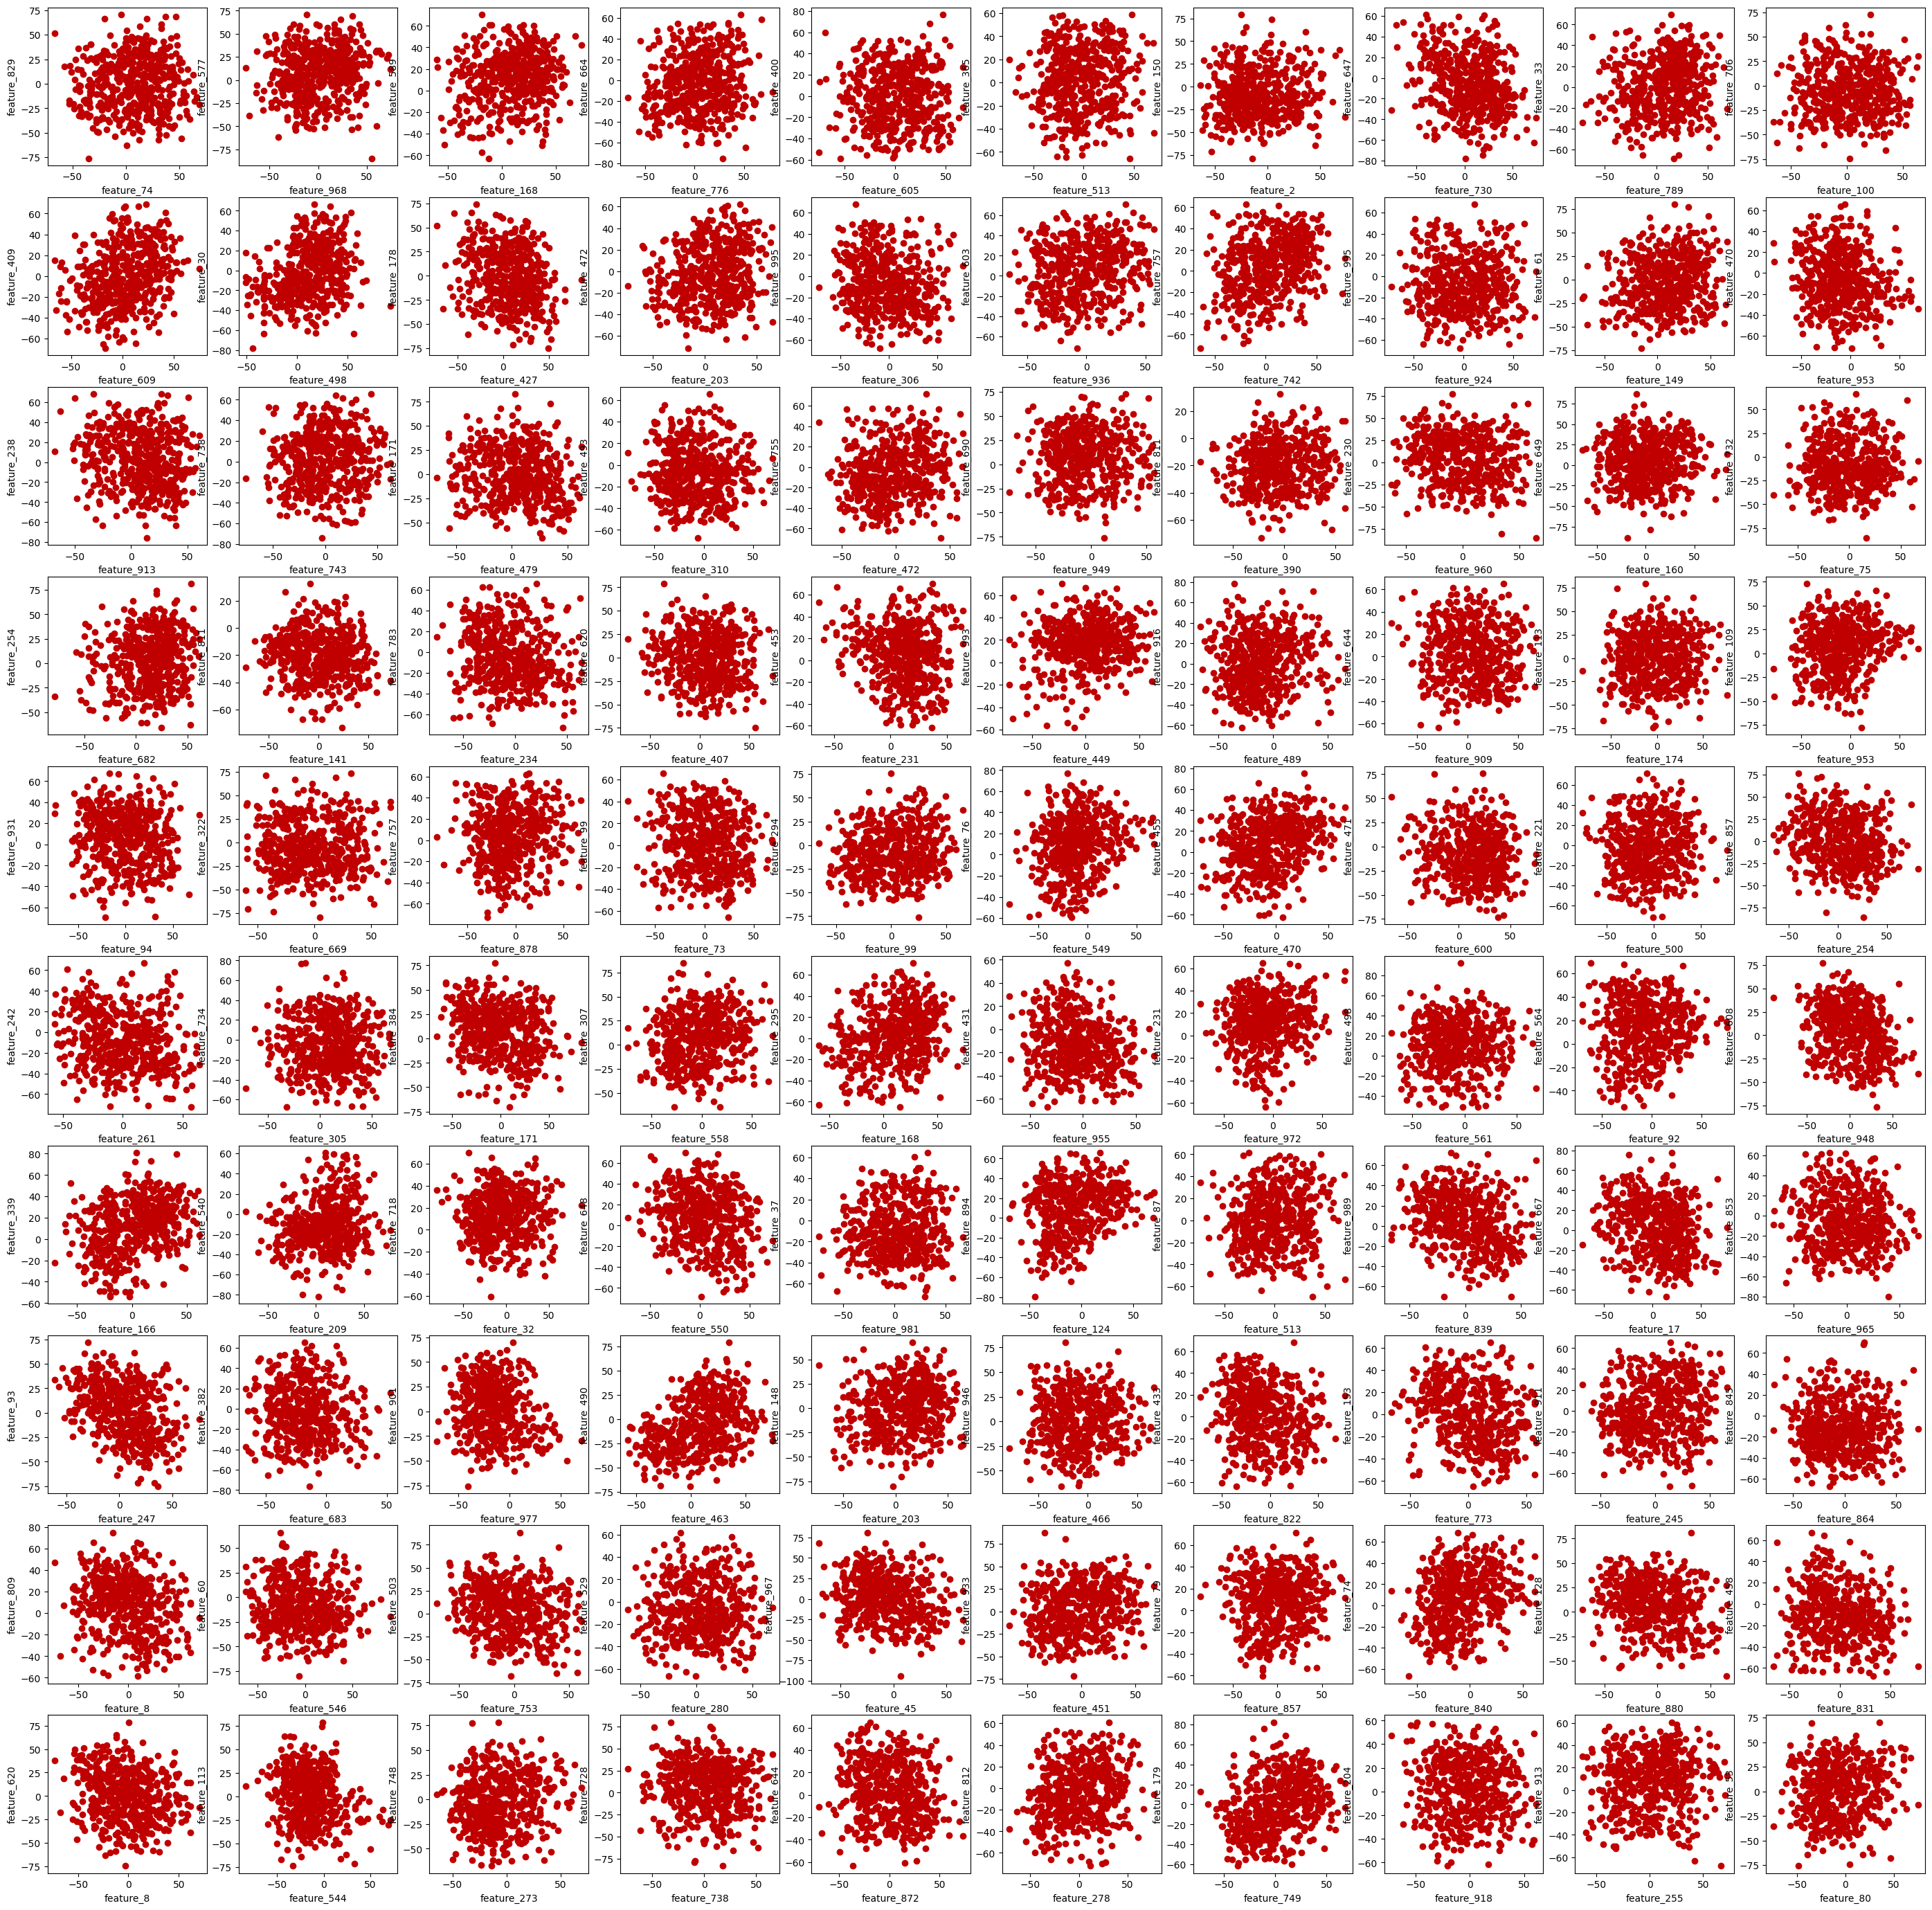

In [31]:
fig, axs = plt.subplots(10,10, figsize = (35,35))
i = 0
for rows in axs:
    for ax in rows:
        ax.scatter(df[pairs[i][0]],df[pairs[i][1]], color = "#C00000")
        ax.set_xlabel(pairs[i][0])
        ax.set_ylabel(pairs[i][1])
        i+=1

It looks like there is not much information hidden in pairwise features. Also, it is not possible to check every combination, due to the amount of features. Let's try to see the linear correlation between them.

In [32]:
# This may take 1 minute to run
corr = df.corr()

In [33]:
## This will show all the features that have correlation > 0.5 in absolute value. We remove the features 
## with correlation == 1 to remove the correlation of a feature with itself

mask = (abs(corr) > 0.5) & (abs(corr) != 1)
corr.where(mask).stack().sort_values()

feature_81   feature_657   -0.631294
feature_657  feature_81    -0.631294
feature_313  feature_4     -0.615317
feature_4    feature_313   -0.615317
feature_716  feature_1     -0.609056
                              ...   
feature_792  feature_547    0.620864
feature_35   feature_965    0.631424
feature_965  feature_35     0.631424
feature_395  feature_985    0.632593
feature_985  feature_395    0.632593
Length: 1870, dtype: float64

The maximum and minimum correlation is around $0.631$ - $0.632$. This does not show too much as well. 

Let's try PCA decomposition to compress our data into a 2-dimensional subspace (plane) so we can plot it as scatter plot. 

In [34]:
# Loading the PCA object
pca = PCA(n_components = 2) # Here we choose the number of components that we will keep.
X_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(X_pca, columns = ['principal_component_1','principal_component_2'])

In [35]:
df_pca.head()

principal_component_1  principal_component_2
0             -46.235641              -1.672797
1            -210.208758             -84.068249
2             -26.352795            -127.895751
3            -116.106804            -269.368256
4            -110.183605            -279.657306

Text(0.5, 1.0, 'PCA decomposition')

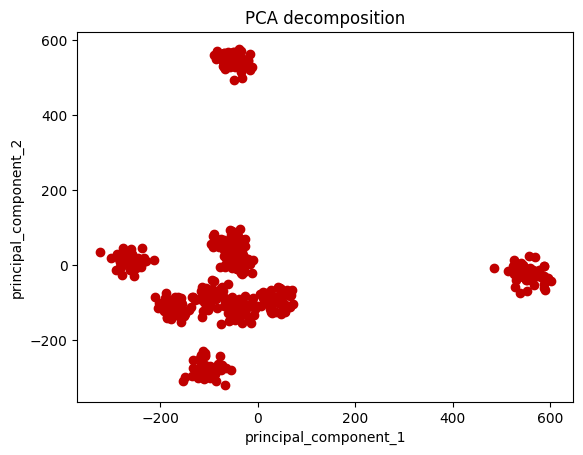

In [36]:
plt.scatter(df_pca['principal_component_1'],df_pca['principal_component_2'], color = "#C00000")
plt.xlabel('principal_component_1')
plt.ylabel('principal_component_2')
plt.title('PCA decomposition')

This is great! We can see well defined clusters. 

In [37]:
# pca.explained_variance_ration_ returns a list where it shows the amount of variance explained by each principal component.
sum(pca.explained_variance_ratio_)

0.14572843555106285

And we preserved only around 14.6% of the variance!

Quite impressive! We can clearly see clusters in our data, something that we could not see before. How many clusters can you spot? 8, 10? 

If we run a PCA to plot 3 dimensions, we will get more information from data.


In [38]:
pca_3 = PCA(n_components = 3).fit(df)
X_t = pca_3.transform(df)
df_pca_3 = pd.DataFrame(X_t,columns = ['principal_component_1','principal_component_2','principal_component_3'])

In [39]:
import plotly.express as px

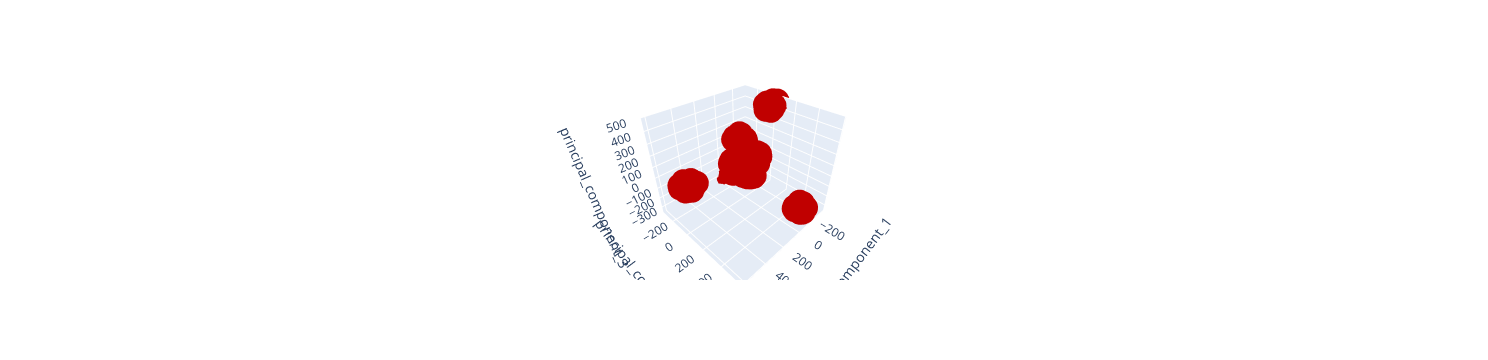

In [40]:
fig = px.scatter_3d(df_pca_3, x = 'principal_component_1', y = 'principal_component_2', z = 'principal_component_3').update_traces(marker = dict(color = "#C00000"))
fig.show()

In [41]:
sum(pca_3.explained_variance_ratio_)

0.20806257816093285

Now we preserved 19% of the variance and we can clearly see 10 clusters.
